# Creating Synthetic Training Pairs for SBERT Fine-tuning

This notebook creates positive and negative pairs using **only job descriptions** to fine-tune SBERT.

**Strategy:**
- **Positive pairs**: Jobs with similar titles and overlapping skills/requirements
- **Hard negative pairs**: Jobs that appear similar (same industry/keywords) but are actually different roles
- **Goal**: Teach SBERT what makes job descriptions semantically similar vs. different

In [1]:
# Fix for TensorFlow compatibility issues
import os

os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from tqdm import tqdm
from collections import defaultdict

random.seed(42)
np.random.seed(42)

## 1. Load Job Description Data

In [2]:
# Load cleaned job descriptions
jd_df = pd.read_excel("../1_data_cleaning/filtered_jd_sections2.xlsx")
print(f"Loaded {len(jd_df)} job descriptions")
print(f"Columns: {jd_df.columns.tolist()}")
print("\nSample data:")
print(jd_df.head(2))

Loaded 1231 job descriptions
Columns: ['job_description', 'location_cleaned', 'job_title', 'jd_duties', 'jd_requirements', 'jd_education']

Sample data:
                                     job_description location_cleaned  \
0  Job SummaryDo you have a strong aptitude for w...       Natick, MA   
1  Overview External: Chevron is one of the world...      Houston, TX   

                                      job_title  \
0  Content Developer for MATLAB Code Generation   
1                                Land Assistant   

                                           jd_duties  \
0  Software components make up an ever larger par...   
1  Overview External: Chevron is one of the world...   

                                     jd_requirements  \
0  Job SummaryDo you have a strong aptitude for w...   
1  Prepare, and secure appropriate approvals for ...   

                                        jd_education  
0  Minimum Qualifications A bachelor's degree and...  
1        Preferred Qualif

## 2. Extract Features from Job Descriptions

In [3]:
# Common skill keywords
skill_keywords = [
    "python",
    "java",
    "javascript",
    "sql",
    r"c\+\+",
    "c#",
    r"\br\b",
    "machine learning",
    "deep learning",
    "nlp",
    "data analysis",
    "statistics",
    "project management",
    "agile",
    "scrum",
    "leadership",
    "communication",
    "sales",
    "marketing",
    "finance",
    "accounting",
    "excel",
    "powerpoint",
    "aws",
    "azure",
    "gcp",
    "docker",
    "kubernetes",
    "git",
    "tensorflow",
    "pytorch",
    "scikit-learn",
    "pandas",
    "numpy",
    "healthcare",
    "nursing",
    "medical",
    "engineering",
    "design",
    "matlab",
    "simulink",
    "embedded",
    "firmware",
    "hardware",
    "legal",
    "attorney",
    "paralegal",
    "contract",
    "compliance",
    "teaching",
    "education",
    "training",
    "curriculum",
]

education_levels = [
    r"bachelor[''']?s?",
    r"master[''']?s?",
    r"phd",
    r"doctorate",
    r"associate",
    r"diploma",
    r"\bba\b",
    r"\bbs\b",
    r"\bma\b",
    r"\bms\b",
    r"\bmba\b",
]


def extract_skills(text):
    """Extract skills from text"""
    if pd.isna(text):
        return []
    text_lower = text.lower()
    found_skills = []
    for skill in skill_keywords:
        if re.search(skill, text_lower):
            found_skills.append(skill.replace("\\b", "").replace("\\+", "+"))
    return found_skills


def extract_education_level(text):
    """Extract education level from text"""
    if pd.isna(text):
        return []
    text_lower = text.lower()
    found_education = []
    for edu in education_levels:
        if re.search(edu, text_lower):
            found_education.append(edu.replace("\\b", "").replace("[''']?s?", "s"))
    return found_education


# Extract features
print("Extracting skills and education levels...")
jd_df["skills"] = jd_df["job_description"].fillna("").apply(extract_skills)
jd_df["education"] = jd_df["job_description"].fillna("").apply(extract_education_level)
jd_df["num_skills"] = jd_df["skills"].apply(len)

print(
    f"\nSkills extracted: {jd_df['num_skills'].sum()} total, {jd_df['num_skills'].mean():.2f} avg per job"
)

Extracting skills and education levels...

Skills extracted: 6371 total, 5.18 avg per job


## 3. Group Jobs by Title Similarity

In [4]:
# Normalize job titles
def normalize_title(title):
    """Normalize job title for grouping"""
    if pd.isna(title):
        return "unknown"
    title = title.lower().strip()
    # Remove common words
    title = re.sub(r"\b(senior|junior|sr|jr|lead|principal|i|ii|iii|iv)\b", "", title)
    title = re.sub(r"\s+", " ", title).strip()
    return title


jd_df["title_normalized"] = jd_df["job_title"].apply(normalize_title)

# Group by normalized title
title_groups = defaultdict(list)
for idx, row in jd_df.iterrows():
    title_groups[row["title_normalized"]].append(idx)

# Keep only titles with multiple jobs (for creating positive pairs)
title_groups = {k: v for k, v in title_groups.items() if len(v) >= 2}

print(f"Found {len(title_groups)} unique normalized job titles")
print(
    f"Total jobs in groups with 2+ members: {sum(len(v) for v in title_groups.values())}"
)

# Show largest groups
sorted_groups = sorted(title_groups.items(), key=lambda x: len(x[1]), reverse=True)
print("\nLargest job title groups:")
for title, indices in sorted_groups[:10]:
    print(f"  {title}: {len(indices)} jobs")

Found 85 unique normalized job titles
Total jobs in groups with 2+ members: 414

Largest job title groups:
  resident nurse: 117 jobs
  project manager: 60 jobs
  manager: 14 jobs
  software engineer: 11 jobs
  shift supervisor: 8 jobs
  quality engineer: 7 jobs
  scrum master: 7 jobs
  database administrator: 5 jobs
  production supervisor: 5 jobs
  physical therapist: 4 jobs


## 4. Compute Embeddings for Similarity Matching

In [5]:
# Load pre-trained SBERT model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create full text representation for each job
jd_df["full_text"] = (
    "Job Title: "
    + jd_df["job_title"].fillna("")
    + ". "
    + "Description: "
    + jd_df["job_description"].fillna("")
    + ". "
    + "Duties: "
    + jd_df["jd_duties"].fillna("")
    + ". "
    + "Requirements: "
    + jd_df["jd_requirements"].fillna("")
    + ". "
    + "Education: "
    + jd_df["jd_education"].fillna("")
)

# Encode all job descriptions
print("Encoding job descriptions...")
embeddings = model.encode(
    jd_df["full_text"].tolist(), show_progress_bar=True, batch_size=32
)

print(f"\nEmbedding shape: {embeddings.shape}")

Encoding job descriptions...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]


Embedding shape: (1231, 384)


## 5. Generate Positive Pairs (Similar Jobs)

In [6]:
def calculate_skill_overlap(skills1, skills2):
    """Calculate Jaccard similarity between skill sets"""
    if not skills1 or not skills2:
        return 0.0
    intersection = len(set(skills1) & set(skills2))
    union = len(set(skills1) | set(skills2))
    return intersection / union if union > 0 else 0.0


def create_positive_pairs(num_pairs=3000, min_skill_overlap=0.3):
    """
    Create positive pairs from jobs with similar titles and overlapping skills
    """
    positive_pairs = []

    print("Creating positive pairs...")

    # Strategy 1: Same normalized title
    for title, indices in tqdm(title_groups.items()):
        # Create pairs within the same title group
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                idx1, idx2 = indices[i], indices[j]

                # Check skill overlap
                skill_overlap = calculate_skill_overlap(
                    jd_df.iloc[idx1]["skills"], jd_df.iloc[idx2]["skills"]
                )

                # Only include if sufficient skill overlap
                if skill_overlap >= min_skill_overlap:
                    # Calculate embedding similarity
                    emb_sim = cosine_similarity(
                        embeddings[idx1].reshape(1, -1), embeddings[idx2].reshape(1, -1)
                    )[0, 0]

                    positive_pairs.append(
                        {
                            "job1_idx": idx1,
                            "job2_idx": idx2,
                            "skill_overlap": skill_overlap,
                            "embedding_similarity": emb_sim,
                            "same_title": 1,
                        }
                    )

                if len(positive_pairs) >= num_pairs:
                    break
            if len(positive_pairs) >= num_pairs:
                break
        if len(positive_pairs) >= num_pairs:
            break

    # Strategy 2: If we need more pairs, find semantically similar jobs
    if len(positive_pairs) < num_pairs:
        print(f"\nNeed {num_pairs - len(positive_pairs)} more positive pairs...")
        print("Finding semantically similar jobs...")

        # Compute similarity matrix
        sim_matrix = cosine_similarity(embeddings)

        for i in tqdm(range(len(jd_df))):
            # Get top similar jobs (excluding self)
            similarities = sim_matrix[i]
            similar_indices = np.argsort(similarities)[::-1][
                1:6
            ]  # Top 5 excluding self

            for j in similar_indices:
                # Check if already paired or same title
                if (
                    jd_df.iloc[i]["title_normalized"]
                    == jd_df.iloc[j]["title_normalized"]
                ):
                    continue

                # Check skill overlap
                skill_overlap = calculate_skill_overlap(
                    jd_df.iloc[i]["skills"], jd_df.iloc[j]["skills"]
                )

                # Require high semantic similarity and some skill overlap
                if similarities[j] >= 0.7 and skill_overlap >= 0.2:
                    positive_pairs.append(
                        {
                            "job1_idx": i,
                            "job2_idx": j,
                            "skill_overlap": skill_overlap,
                            "embedding_similarity": similarities[j],
                            "same_title": 0,
                        }
                    )

                if len(positive_pairs) >= num_pairs:
                    break

            if len(positive_pairs) >= num_pairs:
                break

    return positive_pairs[:num_pairs]


# Generate positive pairs
positive_pairs = create_positive_pairs(num_pairs=3000)
print(f"\nCreated {len(positive_pairs)} positive pairs")

Creating positive pairs...


100%|██████████| 85/85 [00:00<00:00, 97.96it/s]



Need 931 more positive pairs...
Finding semantically similar jobs...


 91%|█████████ | 1118/1231 [00:00<00:00, 1759.03it/s]


Created 3000 positive pairs


## 6. Generate Hard Negative Pairs

In [7]:
def create_hard_negative_pairs(num_pairs=3000, similarity_range=(0.4, 0.7)):
    """
    Create hard negative pairs: jobs that seem similar but are different

    Hard negatives are important for contrastive learning - they help the model
    learn to distinguish between truly similar jobs and superficially similar ones.
    """
    negative_pairs = []

    print("Creating hard negative pairs...")

    # Compute similarity matrix
    sim_matrix = cosine_similarity(embeddings)

    for i in tqdm(range(len(jd_df))):
        similarities = sim_matrix[i]

        # Find jobs in the "hard negative" range:
        # - Not too similar (would be false negative)
        # - Not too dissimilar (would be too easy)
        # - Different job titles
        # - Low skill overlap

        for j in range(len(jd_df)):
            if i == j:
                continue

            # Check if in similarity range
            if not (similarity_range[0] <= similarities[j] <= similarity_range[1]):
                continue

            # Must have different normalized titles
            if jd_df.iloc[i]["title_normalized"] == jd_df.iloc[j]["title_normalized"]:
                continue

            # Check skill overlap (should be low for negatives)
            skill_overlap = calculate_skill_overlap(
                jd_df.iloc[i]["skills"], jd_df.iloc[j]["skills"]
            )

            # Hard negatives: moderate semantic similarity but low skill overlap
            if skill_overlap < 0.3:
                negative_pairs.append(
                    {
                        "job1_idx": i,
                        "job2_idx": j,
                        "skill_overlap": skill_overlap,
                        "embedding_similarity": similarities[j],
                        "same_title": 0,
                    }
                )

            if len(negative_pairs) >= num_pairs:
                break

        if len(negative_pairs) >= num_pairs:
            break

    return negative_pairs[:num_pairs]


# Generate hard negative pairs
negative_pairs = create_hard_negative_pairs(num_pairs=len(positive_pairs))
print(f"\nCreated {len(negative_pairs)} hard negative pairs")

Creating hard negative pairs...


  1%|▏         | 17/1231 [00:00<00:35, 33.75it/s]


Created 3000 hard negative pairs


## 7. Create Training Dataset

In [8]:
# Convert to DataFrames
pos_df = pd.DataFrame(positive_pairs)
pos_df["label"] = 1

neg_df = pd.DataFrame(negative_pairs)
neg_df["label"] = 0

# Combine
pairs_df = pd.concat([pos_df, neg_df], ignore_index=True)

# Shuffle
pairs_df = pairs_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add text data
pairs_df["job1_text"] = pairs_df["job1_idx"].apply(
    lambda idx: jd_df.iloc[idx]["full_text"]
)
pairs_df["job2_text"] = pairs_df["job2_idx"].apply(
    lambda idx: jd_df.iloc[idx]["full_text"]
)

pairs_df["job1_title"] = pairs_df["job1_idx"].apply(
    lambda idx: jd_df.iloc[idx]["job_title"]
)
pairs_df["job2_title"] = pairs_df["job2_idx"].apply(
    lambda idx: jd_df.iloc[idx]["job_title"]
)

print(f"\nTotal pairs: {len(pairs_df)}")
print(f"Positive pairs: {(pairs_df['label'] == 1).sum()}")
print(f"Negative pairs: {(pairs_df['label'] == 0).sum()}")
print(
    f"\nBalance: {(pairs_df['label'] == 1).sum() / len(pairs_df) * 100:.1f}% positive"
)


Total pairs: 6000
Positive pairs: 3000
Negative pairs: 3000

Balance: 50.0% positive


## 8. Quality Analysis

=== POSITIVE PAIRS STATISTICS ===
       skill_overlap  embedding_similarity
count    3000.000000           3000.000000
mean        0.479465              0.626383
std         0.210139              0.189607
min         0.200000              0.105661
25%         0.333333              0.476671
50%         0.400000              0.613446
75%         0.500000              0.757434
max         1.000000              1.000000

=== NEGATIVE PAIRS STATISTICS ===
       skill_overlap  embedding_similarity
count    3000.000000           3000.000000
mean        0.132228              0.452340
std         0.092714              0.043951
min         0.000000              0.400011
25%         0.071429              0.418367
50%         0.133333              0.441656
75%         0.200000              0.475279
max         0.285714              0.695511


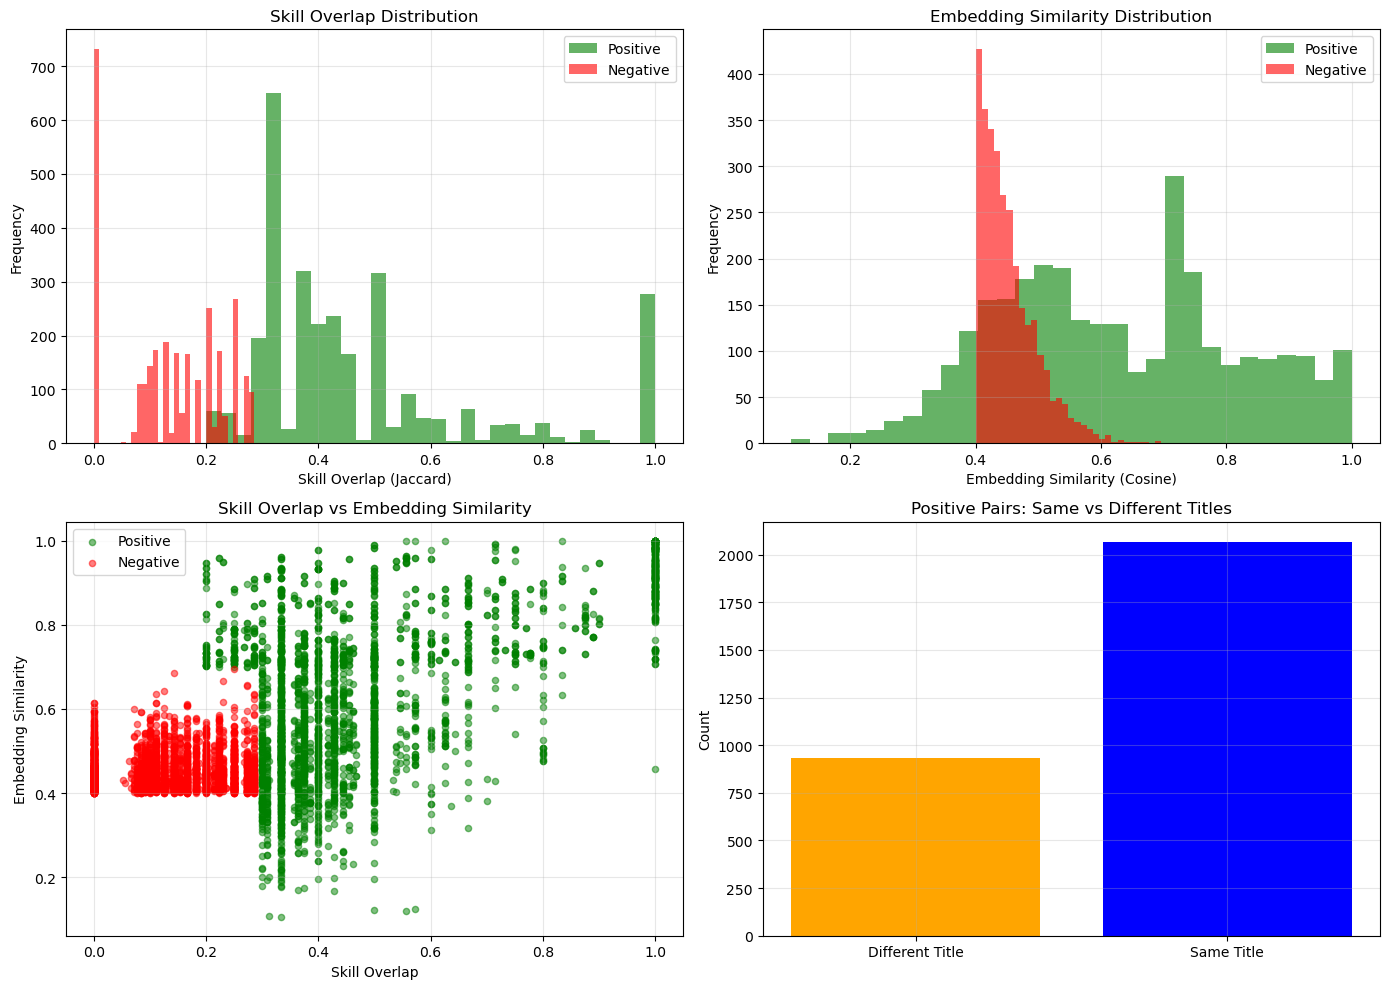


Quality analysis plot saved as 'pair_quality_analysis.png'


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
print("=== POSITIVE PAIRS STATISTICS ===")
print(pos_df[["skill_overlap", "embedding_similarity"]].describe())

print("\n=== NEGATIVE PAIRS STATISTICS ===")
print(neg_df[["skill_overlap", "embedding_similarity"]].describe())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Skill overlap distribution
axes[0, 0].hist(
    pos_df["skill_overlap"], bins=30, alpha=0.6, label="Positive", color="green"
)
axes[0, 0].hist(
    neg_df["skill_overlap"], bins=30, alpha=0.6, label="Negative", color="red"
)
axes[0, 0].set_xlabel("Skill Overlap (Jaccard)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Skill Overlap Distribution")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Embedding similarity distribution
axes[0, 1].hist(
    pos_df["embedding_similarity"], bins=30, alpha=0.6, label="Positive", color="green"
)
axes[0, 1].hist(
    neg_df["embedding_similarity"], bins=30, alpha=0.6, label="Negative", color="red"
)
axes[0, 1].set_xlabel("Embedding Similarity (Cosine)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Embedding Similarity Distribution")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Scatter plot: Skill overlap vs Embedding similarity
axes[1, 0].scatter(
    pos_df["skill_overlap"],
    pos_df["embedding_similarity"],
    alpha=0.5,
    label="Positive",
    color="green",
    s=20,
)
axes[1, 0].scatter(
    neg_df["skill_overlap"],
    neg_df["embedding_similarity"],
    alpha=0.5,
    label="Negative",
    color="red",
    s=20,
)
axes[1, 0].set_xlabel("Skill Overlap")
axes[1, 0].set_ylabel("Embedding Similarity")
axes[1, 0].set_title("Skill Overlap vs Embedding Similarity")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Same title distribution for positive pairs
same_title_counts = pos_df["same_title"].value_counts()
axes[1, 1].bar(
    ["Different Title", "Same Title"],
    [same_title_counts.get(0, 0), same_title_counts.get(1, 0)],
    color=["orange", "blue"],
)
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("Positive Pairs: Same vs Different Titles")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("pair_quality_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nQuality analysis plot saved as 'pair_quality_analysis.png'")

## 9. Show Sample Pairs

In [10]:
# Sample positive pair
print("=" * 80)
print("SAMPLE POSITIVE PAIR (Similar Jobs)")
print("=" * 80)
pos_sample = pairs_df[pairs_df["label"] == 1].iloc[0]
print(f"\nSkill Overlap: {pos_sample['skill_overlap']:.3f}")
print(f"Embedding Similarity: {pos_sample['embedding_similarity']:.3f}")
print(f"\nJob 1: {pos_sample['job1_title']}")
print(f"Text: {pos_sample['job1_text'][:300]}...")
print(f"\nJob 2: {pos_sample['job2_title']}")
print(f"Text: {pos_sample['job2_text'][:300]}...")

# Sample negative pair
print("\n" + "=" * 80)
print("SAMPLE HARD NEGATIVE PAIR (Different Jobs)")
print("=" * 80)
neg_sample = pairs_df[pairs_df["label"] == 0].iloc[0]
print(f"\nSkill Overlap: {neg_sample['skill_overlap']:.3f}")
print(f"Embedding Similarity: {neg_sample['embedding_similarity']:.3f}")
print(f"\nJob 1: {neg_sample['job1_title']}")
print(f"Text: {neg_sample['job1_text'][:300]}...")
print(f"\nJob 2: {neg_sample['job2_title']}")
print(f"Text: {neg_sample['job2_text'][:300]}...")

SAMPLE POSITIVE PAIR (Similar Jobs)

Skill Overlap: 0.300
Embedding Similarity: 0.454

Job 1: Resident Nurse
Text: Job Title: Resident Nurse. Description: Job descriptionAre you looking for a place to call home?  If so, HTB could be the place for you!   With more than 90 years of experience professionally serving its clients’ needs, HTB is among the most respected and successful companies in Louisiana.   Our lon...

Job 2: Resident Nurse
Text: Job Title: Resident Nurse. Description: Job DescriptionI believe that the care we give can make every moment count.Compassionate care, uncompromising service and clinical excellence – that’s how our Hospice improves quality of life in the final stages of life. By delivering palliative care by hospic...

SAMPLE HARD NEGATIVE PAIR (Different Jobs)

Skill Overlap: 0.125
Embedding Similarity: 0.428

Job 1: Client Site Manager for Office Services
Text: Job Title: Client Site Manager for Office Services. Description: Are you looking to work in an envir

## 10. Split into Train/Val/Test Sets

In [11]:
from sklearn.model_selection import train_test_split

# 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(
    pairs_df, test_size=0.3, random_state=42, stratify=pairs_df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

print(f"Train set: {len(train_df)} pairs ")
print(
    f"  - Positive: {(train_df['label']==1).sum()} ({(train_df['label']==1).sum()/len(train_df)*100:.1f}%)"
)
print(
    f"  - Negative: {(train_df['label']==0).sum()} ({(train_df['label']==0).sum()/len(train_df)*100:.1f}%)"
)

print(f"\nValidation set: {len(val_df)} pairs")
print(
    f"  - Positive: {(val_df['label']==1).sum()} ({(val_df['label']==1).sum()/len(val_df)*100:.1f}%)"
)
print(
    f"  - Negative: {(val_df['label']==0).sum()} ({(val_df['label']==0).sum()/len(val_df)*100:.1f}%)"
)

print(f"\nTest set: {len(test_df)} pairs")
print(
    f"  - Positive: {(test_df['label']==1).sum()} ({(test_df['label']==1).sum()/len(test_df)*100:.1f}%)"
)
print(
    f"  - Negative: {(test_df['label']==0).sum()} ({(test_df['label']==0).sum()/len(test_df)*100:.1f}%)"
)

Train set: 4200 pairs 
  - Positive: 2100 (50.0%)
  - Negative: 2100 (50.0%)

Validation set: 900 pairs
  - Positive: 450 (50.0%)
  - Negative: 450 (50.0%)

Test set: 900 pairs
  - Positive: 450 (50.0%)
  - Negative: 450 (50.0%)


## 11. Save Training Data

In [12]:
# Save to CSV
train_df.to_csv("train_pairs.csv", index=False)
val_df.to_csv("val_pairs.csv", index=False)
test_df.to_csv("test_pairs.csv", index=False)

print("\n✓ Training data saved successfully!")
print(f"  - train_pairs.csv: {len(train_df)} pairs")
print(f"  - val_pairs.csv: {len(val_df)} pairs")
print(f"  - test_pairs.csv: {len(test_df)} pairs")

print("\n=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total pairs: {len(pairs_df)}")
print(f"Positive pairs: {(pairs_df['label']==1).sum()}")
print(f"Negative pairs: {(pairs_df['label']==0).sum()}")
print(f"\nData source: Job descriptions only (NO resume data)")
print(f"Positive pairs: Similar job titles + overlapping skills")
print(f"Negative pairs: Different job titles + low skill overlap (hard negatives)")


✓ Training data saved successfully!
  - train_pairs.csv: 4200 pairs
  - val_pairs.csv: 900 pairs
  - test_pairs.csv: 900 pairs

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
SUMMARY
Total pairs: 6000
Positive pairs: 3000
Negative pairs: 3000

Data source: Job descriptions only (NO resume data)
Positive pairs: Similar job titles + overlapping skills
Negative pairs: Different job titles + low skill overlap (hard negatives)
